## 3.-CNN Pytorch

Objetivo, vamos a crear una red convolucional que sea capaz de predecir un tipo de flor determinada a partir de 5 categorías distintas, Rosa, Jacinto, Clavel, Lirio y Margarita. Para ello primero extraeremos la información en bruto desde la página web de Bing que permite descarga directa con un sencillo comando de Python y emplearemos una red CNN ya preentrenada que se puede adaptar perfectamente a nuestro tipo de datos.
En una segunda parte del ejercicio generaremos una CNN desde zero y contrastaremos los resultados.

###  índice
##### 3.1.- Importamos la BBDD
##### 3.2.- Generador automático de Split
##### 3.3.- Definición de los parámetros de aprendizaje de la Red Neuronal
##### 3.4.- Descargamos la Red Preentrenada Alexnet
##### 3.5.- Hiperparámetros de Alexnet
##### 3.6.- Entrenamiento de la Red con nuestos datos
##### 3.7.- Validación del Accuracy de la Red CNN
##### 3.8.- Validación y conclusiones de la CNN
##### 3.9.- Creación Nueva CNN parámetros propios
##### 3.10.- Matriz de confusión y anaĺisis
##### 


#### 3.1.- Importamos la BBDD

In [ ]:
import requests
import re
from bs4 import BeautifulSoup
import wget
import urllib.request
import os
import pathlib
import torch
import numpy as np
import split_folders
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torchvision.transforms import *
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from fastai import *
import warnings
warnings.filterwarnings('ignore')
from bing_image_downloader import downloader
import torchvision.models as models
import matplotlib.pyplot as plt

Descargamos las imagenes desde bing_image_downloader, vamos a  realizar una clasificación de 5 flores: Rosa, Jacinto, Clavel, Lirio y Margarita.

In [ ]:
downloader.download("Daisy flower",     limit=300, adult_filter_off=True, force_replace=False)
downloader.download("Rose flower",      limit=300, adult_filter_off=True, force_replace=False)
downloader.download("carnation flower", limit=300, adult_filter_off=True, force_replace=False)
downloader.download("hyacinth flower",  limit=300, adult_filter_off=True, force_replace=False)
downloader.download("lily flower",      limit=300, adult_filter_off=True, force_replace=False)

#### 3.2.- Generador automático de Split

In [11]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio(f'../dataset/bing/',
                    output=f"../dataset/bing/", seed=737, 
                    ratio=(.7, .2,.1)) # default values

Copying files: 1500 files [00:02, 524.51 files/s]


#### 3.3.- Definición de los parámetros de aprendizaje de la Red Neuronal

In [15]:
# Number of subprocesses to use for data loading
num_workers = 0

# Number of samples per batch to load
batch_size = 32
# Transform train validation and test data
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Loading train and test data
train_data = datasets.ImageFolder('../dataset/bing/train',
                                 transform = transform_train)

val_data = datasets.ImageFolder('../dataset/bing/val',
                                 transform = transform_train)

test_data = datasets.ImageFolder('../dataset/bing/test',
                                transform = transform_test)

In [16]:
# Create dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,                                         
                                         num_workers = num_workers)
validloader = torch.utils.data.DataLoader(val_data, batch_size = batch_size,                                         
                                         num_workers = num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                        num_workers = num_workers)

In [17]:
# Get the classes
root = pathlib.Path('../dataset/bing/train')
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['Daisy flower', 'Rose flower', 'carnation flower', 'hyacinth flower', 'lily flower']


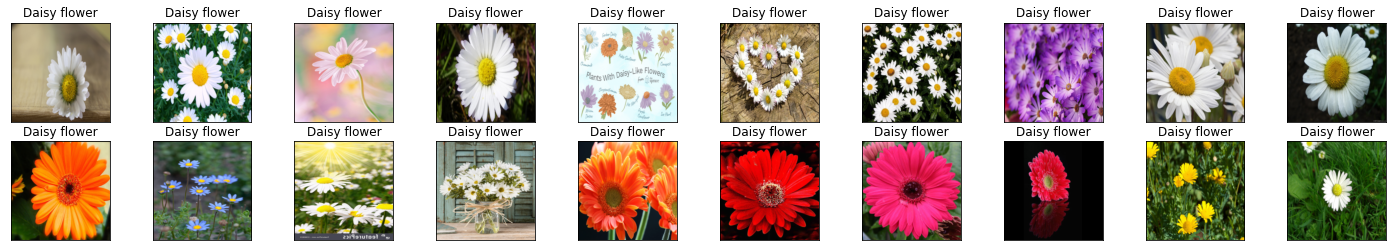

In [18]:
%matplotlib inline
def imshow(img):
    img = img/2 + 0.5 # un-normalize
    plt.imshow(np.transpose(img, (1, 2, 0))) # convert from tensor image
    
# Obtenemos imagenes del train set
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Imagenes con su label
fig = plt.figure(figsize = (25, 4))

#  20 images
for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])

Formato de nuestras imágenes. Esto es importante para los parámetros de la Red

In [19]:
print(images.shape)

(32, 3, 224, 224)


In [ ]:
#orden de los canales colores

#### 3.4.- Descargamos la Red Preentrenada Alexnet

In [20]:
alexnet = models.alexnet(pretrained=True)

In [21]:
#Now using the AlexNet
alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
alexnet.eval()

Using cache found in /home/pablo/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
#Updating the second classifier
alexnet.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network.
#aquí tenemos que actualizar el segundo parametro a 5 que son las categorias a predecir
alexnet.classifier[6] = nn.Linear(1024,5)

In [23]:
#Descripción del Nuevo Modelo
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Verifying CUDA
print(device)
#Move the input and AlexNet_model to GPU for speed if available
alexnet.to(device)

cpu


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### 3.5.- Hiperparámetros de la Red

In [25]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

In [73]:
optim.SGD?

Init signature:
optim.SGD(
    params,
    lr=<required parameter>,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
)
Docstring:     
Implements stochastic gradient descent (optionally with momentum).

Nesterov momentum is based on the formula from
`On the importance of initialization and momentum in deep learning`__.

Args:
    params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
    lr (float): learning rate
    momentum (float, optional): momentum factor (default: 0)
    weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    dampening (float, optional): dampening for momentum (default: 0)
    nesterov (bool, optional): enables Nesterov momentum (default: False)

Example:
    >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    >>> optimizer.zero_grad()
    >>> loss_fn(model(input), target).backward()
    >>> optimizer.step()

__ http://www.cs.toronto.edu/%7Ehinton/absps/

#### 3.6.- Entrenamiento de la Red CNN
10 Epoch, la red ya está preentrenada . Curvas Loss para ver el Epoch

In [26]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = alexnet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Fin del Entrenamiento con AlexNet')

Finished Training of AlexNet


#### 3.7.- Validación del Acc de la Red CNN

In [27]:
#Validation Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy validation images: %d %%' % (
    100 * correct / total))

Accuracy validation images: 93 %


#### 3.8.- Validación y conclusiones de la CNN

In [74]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(5):
    if class_total[i]>0 :
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Daisy flower : 50 %
Accuracy of Rose flower : 100 %
Accuracy of carnation flower : 100 %
Accuracy of hyacinth flower : 100 %
Accuracy of lily flower : 100 %


Los resultados son muy buenos, los problemas vendrán seguramente de que la bbdd obtenida sea confusa.

In [ ]:
#pytorch explanaible para ver en que se fija la red para entredar

#### 3.9.- Creación Nueva CNN parámetros propios

Parametrización de la nueva CNN en Pytorch. 
Vamos a definir una red de 3 capas

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [56]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
      print('CUDA is not available. Training on CPU...')
else:
      print('CUDA is available. Training on GPU')

CUDA is not available. Training on CPU...


In [92]:

import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class IntelImageNet(nn.Module):
      def __init__(self):
        super(IntelImageNet, self).__init__()
        self.conv1 = nn.Conv2d(3,   50,  3, padding = 1)
        self.conv2 = nn.Conv2d(50,  100, 3, padding = 1)
        self.conv3 = nn.Conv2d(100, 224, 3, padding = 1)
        #menos capas 2.
        #tenemos pocos datos
        #capa oculta y otra de salida
        
        self.pool = nn.MaxPool2d(5, 5)
        self.fc1 = nn.Linear(224, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 5)
        self.dropout = nn.Dropout(0.5)
  
      def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) # flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
  

    
model = IntelImageNet()
print(model)

# Move tensors to GPU if CUDA is available
if train_on_gpu:
      model.cuda()

IntelImageNet(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(100, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=224, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [93]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [95]:
# Number of epochs to train the model
num_epochs = 50

valid_loss_min = np.Inf # track the change in validation loss

train_losses = []
valid_losses = []

for epoch in range(1, num_epochs+1):
  # keep track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
  
  #------------------
  # train the model
  #------------------
  model.train()
  for data, target in trainloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
          data, target = data.cuda(), target.cuda()

    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate batch loss
    loss = criterion(output, target)
    
    # backward pass: compute gradient of the loss with respect to the 
    # model parameters
    loss.backward()
    
    # perform parameter update
    optimizer.step()
    
    # update training loss
    train_loss += loss.item()*data.size(0)
    
  #------------------
  # validate the model
  #------------------
  model.eval()
  for data, target in validloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
          data, target = data.cuda(), target.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    
    # update average validation loss
    valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(validloader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  
  # print training and validation stats
  print('Epoch: {} \tTraining Loss: {:.4f} \tValidation loss: {:.4f}'.format(
        epoch, train_loss, valid_loss))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.4f} -> {:.4f}) \n Saving model...'.format(
          valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'intel_image_net.pt')
    valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 1.6173 	Validation loss: 1.6079
Validation loss decreased (inf -> 1.6079) 
 Saving model...
Epoch: 2 	Training Loss: 1.6128 	Validation loss: 1.6071
Validation loss decreased (1.6079 -> 1.6071) 
 Saving model...
Epoch: 3 	Training Loss: 1.6113 	Validation loss: 1.6061
Validation loss decreased (1.6071 -> 1.6061) 
 Saving model...
Epoch: 4 	Training Loss: 1.6111 	Validation loss: 1.6046
Validation loss decreased (1.6061 -> 1.6046) 
 Saving model...
Epoch: 5 	Training Loss: 1.6127 	Validation loss: 1.6021
Validation loss decreased (1.6046 -> 1.6021) 
 Saving model...
Epoch: 6 	Training Loss: 1.6079 	Validation loss: 1.5987
Validation loss decreased (1.6021 -> 1.5987) 
 Saving model...
Epoch: 7 	Training Loss: 1.6057 	Validation loss: 1.5926
Validation loss decreased (1.5987 -> 1.5926) 
 Saving model...
Epoch: 8 	Training Loss: 1.6046 	Validation loss: 1.5843
Validation loss decreased (1.5926 -> 1.5843) 
 Saving model...
Epoch: 9 	Training Loss: 1.5996 	Validation

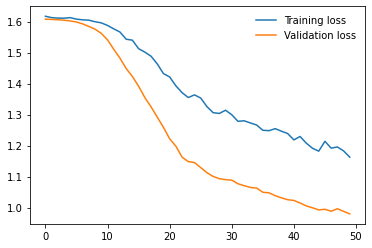

In [96]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon = False)
plt.show()

In [105]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total   = list(0. for i in range(5))

model.eval()
for data, target in testloader:
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    output = model(data)
    loss = criterion(output, target)
  
    test_loss += loss.item()*data.size(0)
     _, pred = torch.max(output, 1)
  
    correct_tensor     = pred.eq(target.data.view_as(pred))
    not_correct_tensor = pred.ne(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  
  for i in range(22):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
    
test_loss = test_loss / len(testloader.dataset)
print('Test loss: {:.4f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (
          classes[i], 100*class_correct[i] / class_total[i], 
          np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest accuracy (Overall): %2d%% (%2d/%2d)' % (
    100.*np.sum(class_correct)/ np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test loss: 1.0166

Test accuracy of Daisy flower: 72% (16/22)
Test accuracy of Rose flower: 72% (16/22)
Test accuracy of carnation flower: 68% (15/22)
Test accuracy of hyacinth flower: 90% (20/22)
Test accuracy of lily flower: 18% ( 4/22)

Test accuracy (Overall): 64% (71/110)


Buenos resultados en general salvo para Los Lirios que el Acc es sólo de 18% . Por ejemplo en Jacinto el Acc del 90% y Rosas del 72%.

#### Matriz de Confusión

In [112]:
nb_classes = 5

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs =  model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


In [113]:
print(confusion_matrix)

tensor([[22.,  1.,  3.,  3.,  1.],
        [ 2., 23.,  2.,  3.,  0.],
        [ 1., 11., 17.,  1.,  0.],
        [ 1.,  0.,  0., 28.,  1.],
        [ 5., 16.,  3.,  0.,  6.]])


Vemos que el problema fundamental es que confunde Lirios con Rosas y Claveles con Rosas que parece más intuitivo.

Viendo en Training loss y Validation parece que la red puede aún mejorar los ratios de entrenamiento por lo que sería iteresante plantearnos el reentrenamiento de la red con un mayor número de Epochs, hasta 100 por ejemplo.